In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression as linreg

In this notebook, I'm trying to figure out a decent estimate for pressure cooking time for mashed potatoes using our InstantPot. Recipes seemed inconsistent, so I went hunting and gathered a small amount of data from recipes listed on the first couple pages of Google. After the first couple, I realized one major source of variation might be the preparation method, so I included that as part of the model: 0 for whole potatoes, 1 for quartered, 2 for slivered/chunked/etc.

In [15]:
# [lbs potatoes, preparation method, cook time (min)] # Source
data = np.array([
    [2, 1, 10], # https://www.skinnytaste.com/instant-pot-mashed-potatoes/
    [4, 0, 20], # https://www.thekitchn.com/recipe-instant-pot-mashed-potatoes-250982
    [3, 2, 8], # https://thesaltymarshmallow.com/instant-pot-mashed-potatoes/
    [4, 1, 8], # https://www.pressurecookrecipes.com/instant-pot-mashed-potatoes/
    [5, 2, 12], # https://www.spendwithpennies.com/instant-pot-mashed-potatoes/
    [2, 0, 20], # https://www.jessicagavin.com/instant-pot-mashed-potatoes/
    [2, 2, 10], # https://therecipecritic.com/instant-pot-mashed-potatoes/
    [2.5, 2, 8], # https://www.thespruceeats.com/instant-pot-mashed-potatoes-4132338
    [2, 2, 10], # https://www.thereciperebel.com/instant-pot-mashed-potatoes-recipe/
    [2, 1, 10], # https://www.dinneratthezoo.com/instant-pot-mashed-potatoes/
    [3, 2, 10], # https://amindfullmom.com/instant-pot-mashed-potatoes/
    [3, 1, 12], # https://www.delish.com/cooking/recipe-ideas/a24686405/instant-pot-mashed-potatoes/
    [2.4, 1, 8] # https://www.apinchofhealthy.com/instant-pot-mashed-potatoes/
])

##### Note
One recipe was excluded because it seemed to not really fit either the whole potatoes (other recipes have 20 min) nor the quartered (max time of 12 min), and although it's totally hacky and unprofessional, I just want perfect potatoes for my small group tonight and don't have time to try this twice today.
```
[5, 0, 15], # https://www.foodnetwork.com/recipes/food-network-kitchen/instant-pot-mashed-potatoes-5296006
```

Finally, after playing around, I decided use a multiple linear regression from the raw data pretty-much as is (rather than introducing [dummy variables](https://en.wikipedia.org/wiki/Dummy_variable_(statistics)), for example), really for no reason other than, I just wanted a quick estimate.

However, I did scale the preparation variable to whole = 0, quartered = 1, chunks = sqrt(2), just because this seems fitting based on my own cooking experience, in that whole potatoes take *forever* to cook, and chunks are fast, but not twice as fast as quarters. Again, want a quick estimate, but one I can use tonight.

In [16]:
data[:,1] = data[:, 1] ** 0.5  # rescaling the chunks to be sqrt(2)
lr = linreg().fit(data[:,[0,1]], data[:,2])  # fit the data with multiple linear regression

Next, prepare the graph, coloring the recipes by their preparation method, and showing predictions for each method using the same multiple linear regression model.

In [17]:
# Slight abstraction so I can quickly change between methods of encoding the preparation method
vals = np.unique(data[:,1])
levels = 3
names = ["whole", "quartered", "chunks"]
cmap = plt.get_cmap("cool")

fig, ax = plt.subplots(1, figsize=(8,8))

ax.scatter(data[:,0], data[:,2], color=cmap(data[:,1] / 2), label="data")
for i in range(levels):
    xlin = np.array([[1.0, vals[i]], [6.0, vals[i]]])
    ylin = lr.predict(xlin)
    col = cmap(vals[i]/2)
    ax.plot(xlin[:,0], ylin, color=col, label=names[i])
ax.set_title("Instant Pot Mashed Potato Recipes")
ax.set_xlabel("potatoes (lbs)")
ax.set_ylabel("pressure cook time (min)")
ax.legend(loc="best");  # semicolon to suppress output

Lastly, I wanted to compare with the mashed potato recipe on the official InstantPot site: https://recipes.instantpot.com/recipe/pressure-cooker-mashed-potatoes/, so that's included as a purple star (their recipe uses quarters)

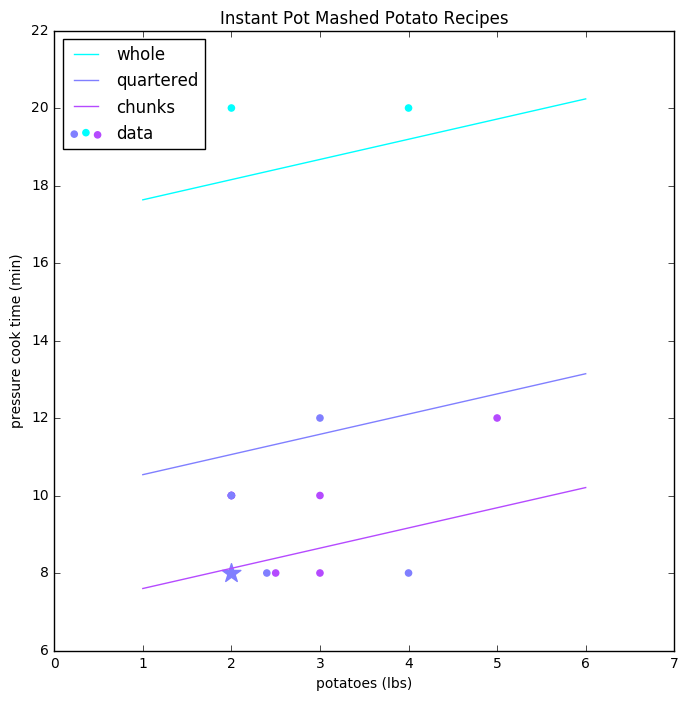

In [18]:
gold = [2, 1, 8]
ax.scatter([gold[0]], [gold[2]], color=cmap(vals[gold[1]] / 2), s=200, marker="*")
plt.show()

# Discussion
So, the model seems to miss a bit, in that it predicts an ~11 minute pressure cook for the "official" recipe, but the recipe actually cooks for 8 minutes. Unfortunately, I can't blame that on the official recipe using the "natural" release mechanism of the InstantPot (wherein the whole cooker comes down in pressure and temperature over a longer timespan), so I'm just not sure.

I think ideally, I'd weight the datapoints in the model based on reviews (all had some sort of 5-star scale), but that's for a future endeavor, mainly because it would involve going back to all the websites, and I should get cooking instead pretty soon.

Tonight, I have roughly 4.3 lbs of potatoes, which gives the following cook times with the various methods:

In [39]:
tonight = 4.3
x = np.array([[tonight, np.sqrt(i)] for i in range(levels)])
pred = lr.predict(x)
for i in range(levels):
    print("%-9s %.1f min" % (names[i], pred[i]))

whole     19.3 min
quartered 12.3 min
chunks    9.3 min


## Decision
In this case, I think I'm going to go quartered for 12 minutes. Two of the recipes for larger amounts of potatoes that used chunks require much more cook time than the model predicts, so I'm concerned about undercooking using that prediction. I've been there with a sweet potato recipe before, and don't really want to do that again. At 12 minutes for 4.3 pounds of quartered potatoes, I'm matching the max cook time outside of whole potatoes (which, again, been there, and don't want to deal with that today). So I feel like this should cook decently without dramatically overcooking or undercooking.